In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import zscore

In [2]:
# Load the dataset
data_path = 'Total_Crops.csv'  # Update with the correct path if needed
df = pd.read_csv(data_path)

In [3]:
# Display the dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85260 entries, 0 to 85259
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mandiid          85260 non-null  int64 
 1   cropid           85260 non-null  int64 
 2   cropname         85260 non-null  object
 3   mandiname        85260 non-null  object
 4   arrivalquantity  85260 non-null  int64 
 5   maximumprice     85260 non-null  int64 
 6   minimumprice     85260 non-null  int64 
 7   modalprice       85260 non-null  int64 
 8   date             85260 non-null  object
dtypes: int64(6), object(3)
memory usage: 5.9+ MB


In [4]:
# Convert relevant columns to integer data type
df['cropid'] = df['cropid'].astype(int)
df['mandiid'] = df['mandiid'].astype(int)

In [5]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract year, month, day from 'date'
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# Drop rows with invalid 'date'
df.dropna(subset=['date'], inplace=True)

In [6]:
# Display the columns to verify the 'date' column exists
print("Columns in the dataset:", df.columns)

Columns in the dataset: Index(['mandiid', 'cropid', 'cropname', 'mandiname', 'arrivalquantity',
       'maximumprice', 'minimumprice', 'modalprice', 'date', 'year', 'month',
       'day'],
      dtype='object')


In [7]:
# Ensure the dataset contains 'cropid' and 'mandiid' columns
if 'cropid' in df.columns and 'mandiid' in df.columns:
    # Get the count of entries for each combination of 'cropid' and 'mandiid'
    combination_counts = df.groupby(['cropid', 'mandiid']).size().reset_index(name='count')

    # Sort the combinations by count in descending order
    combination_counts_sorted = combination_counts.sort_values(by='count', ascending=False)

    # Get the top 10 unique entries based on the counts
    top_10_unique_combinations = combination_counts_sorted.head(10)

    # Print the top 10 unique combinations without indexes
    print(top_10_unique_combinations.to_string(index=False))
else:
    print("The dataset does not contain the required 'cropid' and 'mandiid' columns.")

 cropid  mandiid  count
      7      227    986
     13      359    959
      7      981    934
      1     1122    926
      1     1129    902
      1     1142    902
      7     1331    877
      1     1235    863
     13      167    859
      1     1212    859


In [8]:
# Function to get user inputs
def get_user_inputs():
    cropid = int(input("Enter cropid: "))
    mandiid = int(input("Enter mandiid: "))
    n_days = int(input("Enter the number of days to predict: "))
    return cropid, mandiid, n_days

cropid, mandiid, n_days = get_user_inputs()

Enter cropid:  7
Enter mandiid:  227
Enter the number of days to predict:  10


In [9]:
# Filter the dataframe based on cropid and create a copy to avoid SettingWithCopyWarning
df_filtered = df[df['cropid'] == cropid].copy()
cropname = df_filtered['cropname'].iloc[0] if not df_filtered.empty else 'UnknownCrop'

# Remove outliers using the Z-score method
df_filtered['zscore'] = zscore(df_filtered['modalprice'])
df_filtered = df_filtered[(df_filtered['zscore'].abs() <= 3)]
df_filtered.drop(columns=['zscore'], inplace=True)


In [10]:
# Features and target variable
X = df_filtered[['year', 'month', 'day']]
y = df_filtered['modalprice']

In [11]:
# Train the Gradient Boosting Regressor model on the entire dataset for the given cropid
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X, y)

GradientBoostingRegressor(random_state=42)

In [12]:
# Set the fixed starting date for future predictions
start_date = datetime(2024, 3, 4)
future_dates = [start_date + timedelta(days=i) for i in range(n_days)]
future_dates_df = pd.DataFrame(future_dates, columns=['date'])
future_dates_df['year'] = future_dates_df['date'].dt.year
future_dates_df['month'] = future_dates_df['date'].dt.month
future_dates_df['day'] = future_dates_df['date'].dt.day

# Predict future prices
future_X = future_dates_df[['year', 'month', 'day']]
future_predictions = model.predict(future_X)

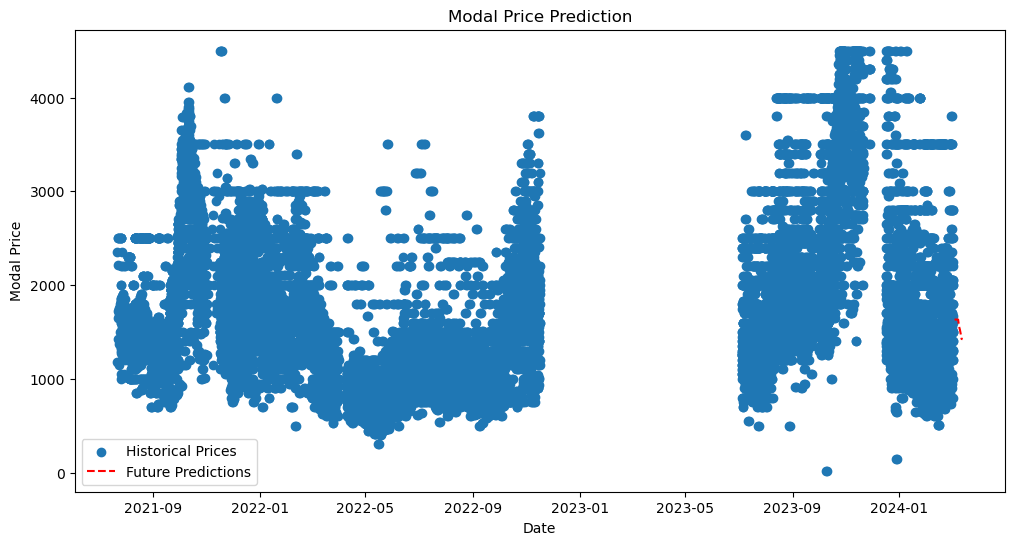

In [13]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.scatter(df_filtered['date'], df_filtered['modalprice'], label='Historical Prices')
plt.plot(future_dates_df['date'], future_predictions, label='Future Predictions', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Modal Price')
plt.title('Modal Price Prediction')
plt.legend()
plt.show()

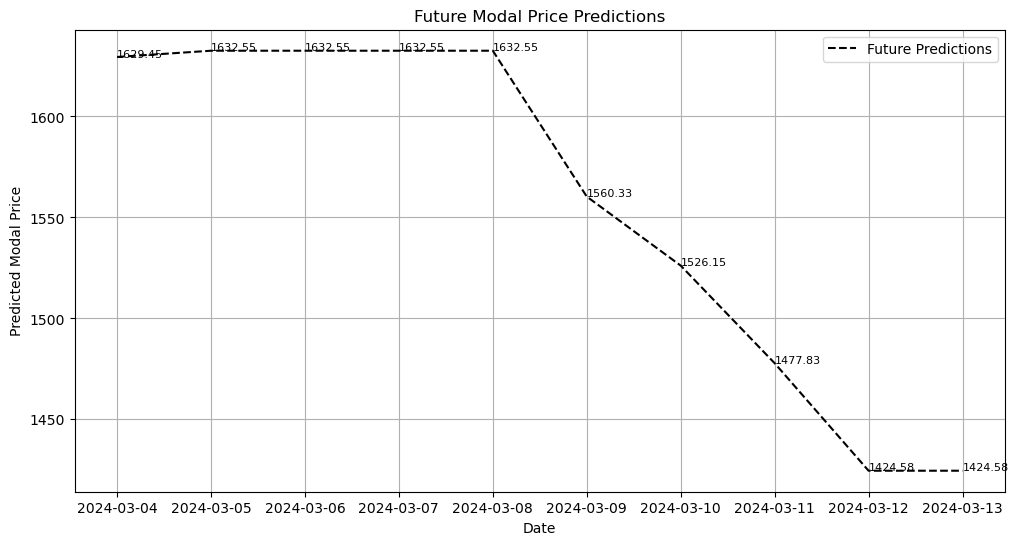

In [14]:
# Standalone visualization for future predictions with data point labels
plt.figure(figsize=(12, 6))
plt.plot(future_dates_df['date'], future_predictions, label='Future Predictions', color='black', linestyle='--')
for i, txt in enumerate(future_predictions):
    plt.text(future_dates_df['date'][i], future_predictions[i], f'{txt:.2f}', fontsize=8)
plt.xlabel('Date')
plt.ylabel('Predicted Modal Price')
plt.title('Future Modal Price Predictions')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Convert predictions to a DataFrame
predicted_df = pd.DataFrame(future_predictions, columns=['predicted_price'])

# Save the predictions to a CSV file
output_path = f'Predicted_{cropname}_ML.csv'
predicted_df.to_csv(output_path, index=False)

print(f"Predictions saved to {output_path}")

Predictions saved to Predicted_Onion_ML.csv
